In [143]:
from __future__ import print_function
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import pandas as pd
import os, time, gc, datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb
import lime
import lime.lime_tabular
np.random.seed(1)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [144]:
def load_data():
    
    train_transaction = pd.read_csv("train_transaction.csv")
    train_identity = pd.read_csv("train_identity.csv")
    data=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
    
    return data

In [145]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [146]:
data = load_data()
data=reduce_mem_usage(data)

Mem. usage decreased to 650.48 Mb (66.8% reduction)


In [147]:
print(data.shape)

(590540, 434)


In [148]:
V_cols = [x for x in data.columns if x[0] == 'V']
V_cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 

In [149]:
data = data.sort_values('TransactionDT')
print(data.shape)

(590540, 434)


In [150]:
#Removing all V columns 

data = data.drop(columns = V_cols, axis = 1)

print(data.shape)

(590540, 95)


In [151]:
#Removing all ID columns 

data = data.drop(columns = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
                 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
                 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
                 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'], axis = 1)

print(data.shape)

(590540, 57)


In [152]:
#Removing all categorical columns 

data = data.drop(columns= ['ProductCD','DeviceType','DeviceInfo','TransactionID', 'P_emaildomain','R_emaildomain',   
                            'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4','card5', 'card6','dist1', 'dist2', 
                       'D1', 'D2', 'D3', 'D4','D5', 'D6', 'D7', 'D8', 'D9', 'D10','D11','D12', 'D13', 'D14', 'D15', 
                            'M1','M2', 'M3','M4', 'M5',  'M6', 'M7', 'M8', 'M9'], axis = 1)

print(data.shape)


(590540, 17)


In [153]:
data.head()

,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,86400,68.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,0,86401,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0,86469,59.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,86499,50.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,86506,50.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [154]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
data['Date']

0        2017-12-02 00:00:00
1        2017-12-02 00:00:01
2        2017-12-02 00:01:09
3        2017-12-02 00:01:39
4        2017-12-02 00:01:46
                 ...        
590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: Date, Length: 590540, dtype: datetime64[ns]

In [155]:
#Label encoding

number = LabelEncoder()
for i in data.columns:
    if (data[i].dtype == 'object'):
        data[i] = number.fit_transform(data[i].astype('str'))
        data[i] = data[i].astype('object')

### Check and visulaize Fraud to Non-fraud Ratio

In [160]:
All = data.shape[0]
fraud = data[data['isFraud'] == 1]
normal = data[data['isFraud'] == 0]

x = len(fraud)/All
y = len(normal)/All

print('Frauds :',x*100,'%')
print('Non-Frauds :',y*100,'%')

Frauds : 3.472776597031431 %
Non-Frauds : 96.52722340296856 %


In [161]:
data=data.sample(frac=0.7, random_state=1)

outlier_frac=len(fraud)/float(len(normal))
print(outlier_frac)

print('Fraud cases: {}'.format(len(fraud)))
print('Non-Fraud cases: {}'.format(len(normal)))

0.0359771728078592
Fraud cases: 10049
Non-Fraud cases: 279316


Text(0, 0.5, 'Frequency')

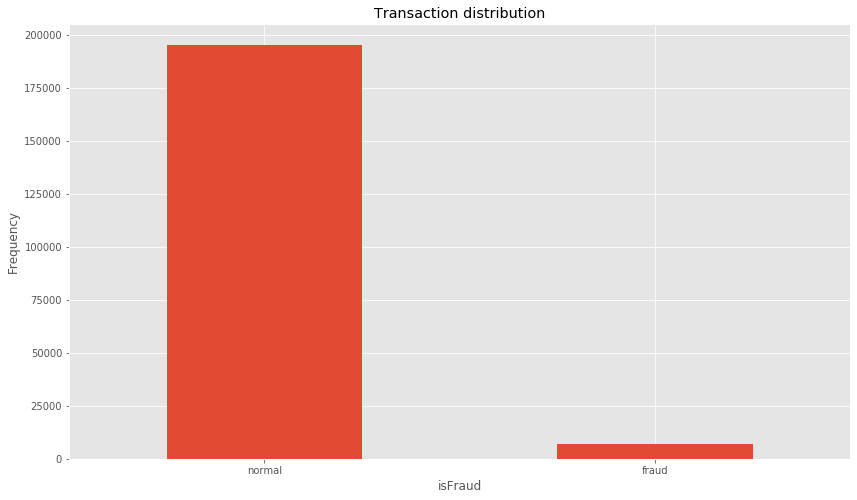

In [162]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Transaction class against the Frequency
labels = ['normal','fraud']
classes = pd.value_counts(data['isFraud'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction distribution")
plt.xticks(range(2), labels)
plt.xlabel("isFraud")
plt.ylabel("Frequency")

### Plotting the distribution of features

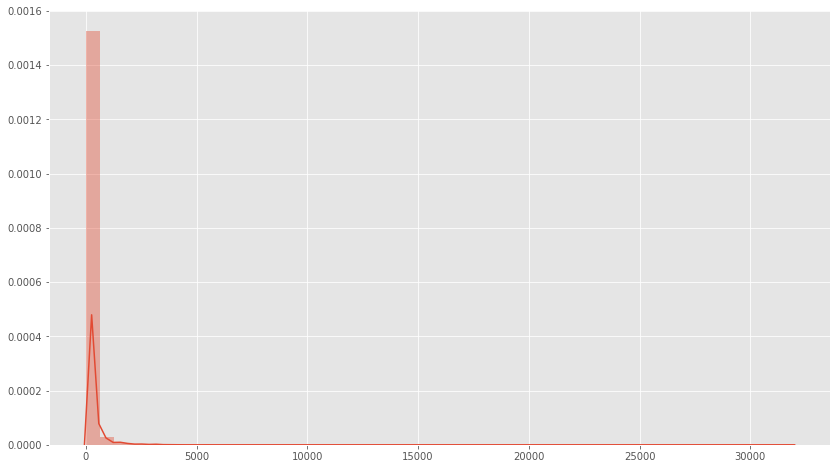

In [163]:
import seaborn as sns

# distribution of Amount
amount = [data['TransactionAmt'].values]
sns.distplot(amount)

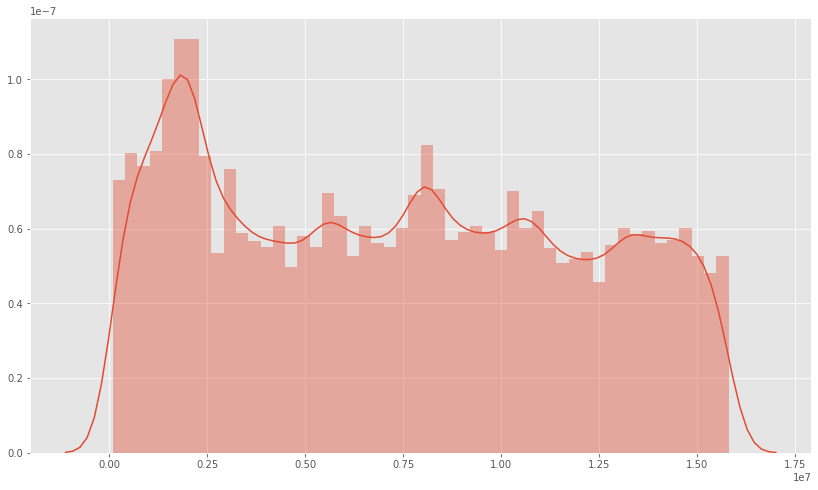

In [164]:
# distribution of Transaction Time

time = [data['TransactionDT'].values]
sns.distplot(time)

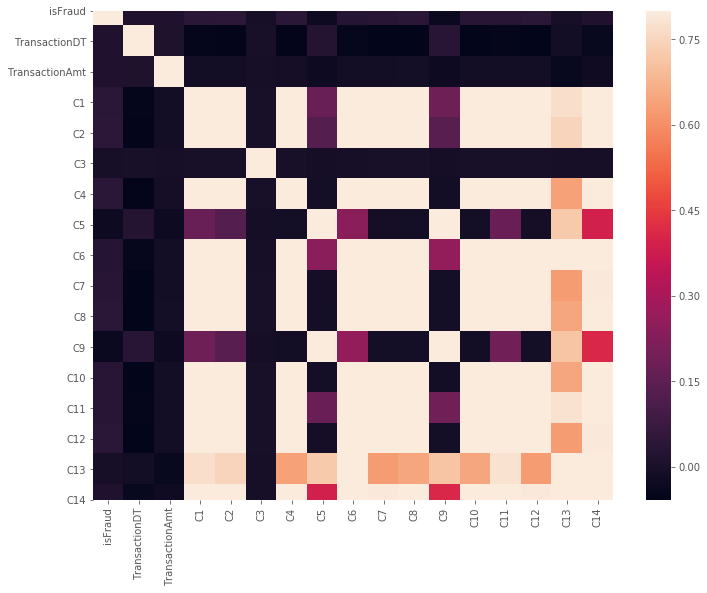

In [165]:
# heat map of correlation of features
correlation_matrix = data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [166]:
d1 = datetime.datetime(2018, 5, 1)
train = data[data['Date']<d1]
test = data [data['Date']>= d1]

In [167]:
y = train['isFraud'].copy()
conta = sum(y) / len(y)

df  = train.drop(columns = ['Date'], axis = 1)
X  = df.drop(columns = ['isFraud'], axis = 1)

X_test1 = test.drop('Date', axis = 1)
X_test  = test.drop(columns = ['isFraud', 'Date'], axis = 1)
y_test = X_test1['isFraud'].copy()

In [168]:
# Handling missing value

from sklearn.impute import SimpleImputer

print('Filling NaNs with mean')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df[:] = imp_mean.fit_transform(df.replace(np.inf, 99999).values)


Filling NaNs with mean


In [169]:
# Handling missing value

print('Filling NaNs with mean')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_test[:] = imp_mean.fit_transform(X_test.replace(np.inf, 99999).values)

Filling NaNs with mean


In [170]:
feat = X.columns
print(feat)

Index(['TransactionDT', 'TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype='object')


### PCA transformation

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [26]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.head()

,principal component 1,principal component 2,isFraud
0,-4.538234e+06,-52.916688,0.0
1,-2.022039e+06,-40.642442,0.0
2,5.513727e+06,0.097942,0.0
3,6.454344e+06,-2.480482,0.0
4,3.501529e+06,-1.873662,0.0


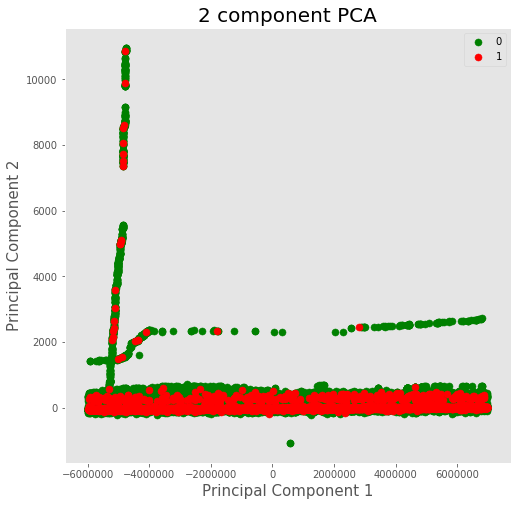

In [27]:
# 2D visualization
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['isFraud'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [28]:
#Since the data is highly imbalanced, taking only 200 rows from the non_fraud transactions.

# Lets shuffle the data before creating the subsamples
df = df.sample(frac=1)

frauds = df[df['isFraud'] == 1]
non_frauds = df[df['isFraud'] == 0][:200]

new_data = pd.concat([non_frauds, frauds])

# Shuffle dataframe rows
new_data = new_data.sample(frac=1, random_state=42)

new_data.head()

,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
34831,1.0,855367.0,29.0000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
257160,1.0,6159876.0,57.9375,4.0,6.0,0.0,0.0,9.0,4.0,0.0,0.0,6.0,0.0,3.0,0.0,20.0,4.0
95839,1.0,1966372.0,150.0000,19.0,22.0,0.0,12.0,0.0,10.0,0.0,15.0,0.0,16.0,11.0,0.0,6.0,5.0
254362,1.0,6079109.0,35.9375,4.0,5.0,0.0,0.0,9.0,4.0,0.0,0.0,6.0,0.0,3.0,0.0,20.0,4.0
199488,1.0,4525047.0,226.0000,5.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0


In [29]:
# prepare the data
features = new_data.drop(['isFraud'], axis = 1)
labels = pd.DataFrame(new_data['isFraud'])

feature_array = features.values
label_array = labels.values

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# splitting the feature array and label array keeping 80% for the trainnig sets
X_train,X_test,y_train,y_test = train_test_split(feature_array,label_array,test_size=0.20)

# normalize: Scale input vectors individually to unit norm (vector length).
X_train = normalize(X_train)
X_test=normalize(X_test)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

neighbours = np.arange(1,25)
train_accuracy =np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_train,y_train.ravel())
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train.ravel())
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test.ravel()) 

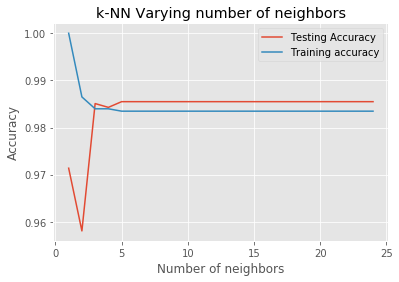

In [32]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
plt.plot(neighbours, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [33]:
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]

In [34]:
#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,y_train.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [35]:
from sklearn.externals import joblib

# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(knn, filename)

/home/hs/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['finalized_model.sav']

In [36]:
# load the model from disk
knn = joblib.load(filename)

In [37]:
# predicting labels for testing set
knn_predicted_test_labels=knn.predict(X_test)

Text(0.5, 1.0, ' Number of Blobs')

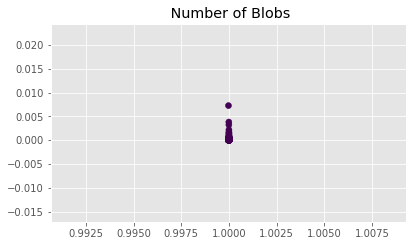

In [38]:
from pylab import rcParams
#plt.figure(figsize=(12, 12))
rcParams['figure.figsize'] = 14, 8
plt.subplot(222)
plt.scatter(X_test[:, 0], X_test[:, 1], c=knn_predicted_test_labels)
plt.title(" Number of Blobs")

In [39]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve

#scoring knn
knn_accuracy_score  = accuracy_score(y_test,knn_predicted_test_labels)
knn_precison_score  = precision_score(y_test,knn_predicted_test_labels)
knn_recall_score    = recall_score(y_test,knn_predicted_test_labels)
knn_f1_score        = f1_score(y_test,knn_predicted_test_labels)
knn_MCC             = matthews_corrcoef(y_test,knn_predicted_test_labels)

/home/hs/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [40]:
#printing
print("")
print("K-Nearest Neighbours")
print("Scores")
print("Accuracy -->",knn_accuracy_score)
print("Precison -->",knn_precison_score)
print("Recall -->",knn_recall_score)
print("F1 -->",knn_f1_score)
print("MCC -->",knn_MCC)
print(classification_report(y_test,knn_predicted_test_labels))


K-Nearest Neighbours
Scores
Accuracy --> 0.9854838709677419
Precison --> 0.9854838709677419
Recall --> 1.0
F1 --> 0.9926888708367182
MCC --> 0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.99      1.00      0.99      2444

    accuracy                           0.99      2480
   macro avg       0.49      0.50      0.50      2480
weighted avg       0.97      0.99      0.98      2480



/home/hs/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


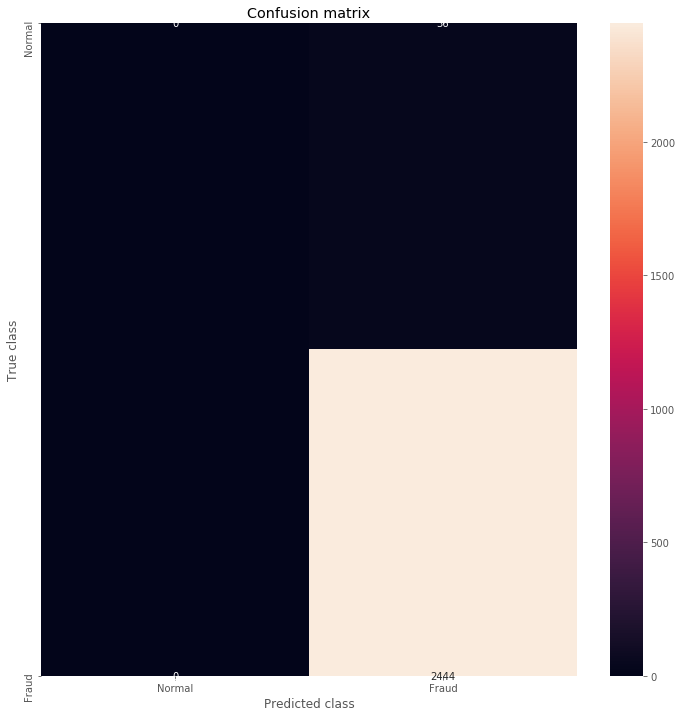

In [41]:
import seaborn as sns
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, knn_predicted_test_labels)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Lime vs TreeInterpreter for interpreting decision tree

In [42]:
from treeinterpreter import treeinterpreter as ti

dt = DecisionTreeClassifier().fit(X, y) 

In [43]:
prediction, bias, contrib = ti.predict(dt, X_test)

In [44]:
prediction[0]

array([1., 0.])

In [45]:
#Using LIME library

explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=feat, discretize_continuous=False)

i = 0
exp = explainer.explain_instance(X.loc[i, feat].astype(int).values, dt.predict_proba, 
                                 num_features=5, top_labels=2)

exp.show_in_notebook(show_table=True,  predict_proba= True , show_predicted_value = True , show_all=False)

In [46]:
#This block is running little bit long

"""for i in range(len(X_test)):

    print ("prediction:",prediction)

    print ("-"*5) 

    print ("Feature contributions for the misprediction:")

    print ("-"*5) 

    for c, features in sorted(zip(contrib[i], X_train.columns), 
                              key=lambda x: ~abs(x[0].any())):
        print (features, c)"""

'for i in range(len(X_test)):\n\n    print ("prediction:",prediction)\n\n    print ("-"*5) \n\n    print ("Feature contributions for the misprediction:")\n\n    print ("-"*5) \n\n    for c, features in sorted(zip(contrib[i], X_train.columns), \n                              key=lambda x: ~abs(x[0].any())):\n        print (features, c)'

In [47]:
v_arr = df.columns.ravel()[3:17]
desc = df[v_arr].describe().T
kurt = pd.Series([df[i].kurt() for i in v_arr], name="Kurt", index=v_arr)
skew = pd.Series([df[i].skew() for i in v_arr], name="Skew", index=v_arr)
desc = pd.concat([desc, kurt, skew], axis=1)

desc

,count,mean,std,min,25%,50%,75%,max,Kurt,Skew
C1,348910.0,14.726755,139.647805,0.0,1.0,1.0,3.0,4684.0,611.831188,22.965356
C2,348910.0,16.031421,162.168992,0.0,1.0,1.0,3.0,5692.0,593.359905,22.585920
C3,348910.0,0.005302,0.146674,0.0,0.0,0.0,0.0,25.0,11986.261666,93.749744
C4,348910.0,4.392935,71.458781,0.0,0.0,0.0,0.0,2252.0,504.502317,21.264782
C5,348910.0,5.500748,25.463653,0.0,0.0,0.0,1.0,335.0,35.934458,5.793231
C6,348910.0,9.366805,73.966901,0.0,1.0,1.0,2.0,2252.0,435.433246,19.175007
C7,348910.0,3.222685,65.541870,0.0,0.0,0.0,0.0,2254.0,686.236897,25.245144
C8,348910.0,5.676685,100.983096,0.0,0.0,0.0,0.0,3330.0,650.412110,24.424155
C9,348910.0,4.398123,16.487771,0.0,0.0,1.0,2.0,210.0,36.884969,5.766113
C10,348910.0,5.807237,101.470654,0.0,0.0,0.0,0.0,3256.0,600.325545,23.551988


In [48]:
kurt = pd.Series([df[i].kurt() for i in v_arr], name="Kurt", index=v_arr)
skew = pd.Series([df[i].skew() for i in v_arr], name="Skew", index=v_arr)

#Sorting value with lowest kurtosis and skewness
df_kurt = desc.sort_values("Kurt")
df_skew = desc.sort_values("Skew")

In [49]:
def plot_dist(df, arr):
    mask0 = df["isFraud"] == 0
    mask1 = df["isFraud"] == 1

    for i in arr:
        plt.figure(figsize=(14,6))
        plt.title(i)
        sns.distplot(df[i][mask0])
        sns.distplot(df[i][mask1])
        plt.legend(["Not Fraud", "Fraud"])
        plt.grid()

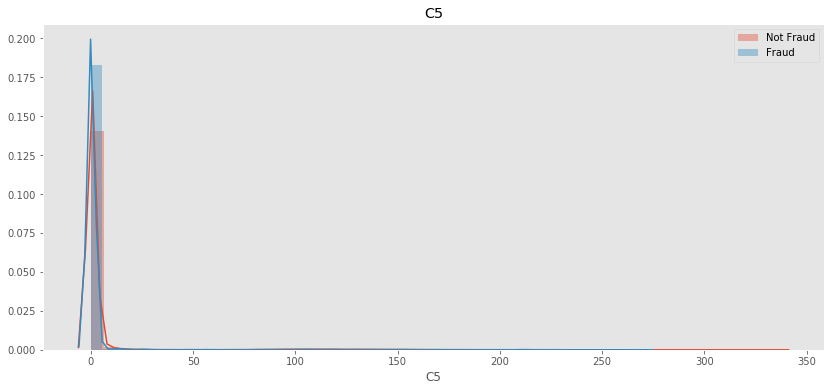

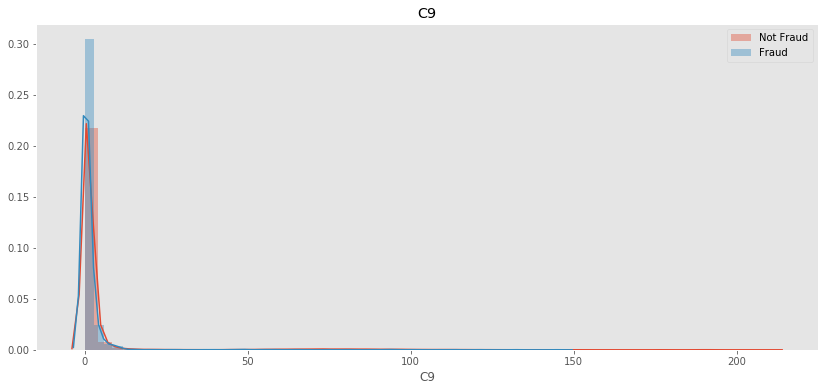

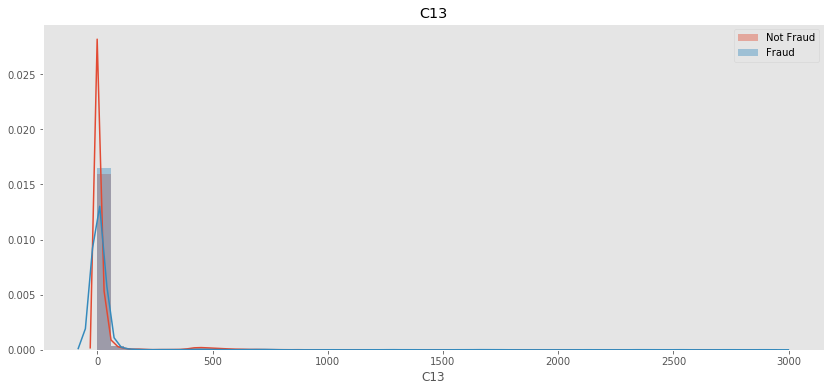

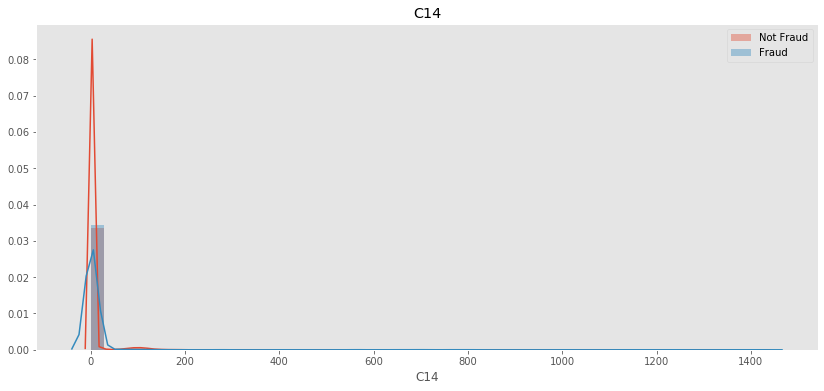

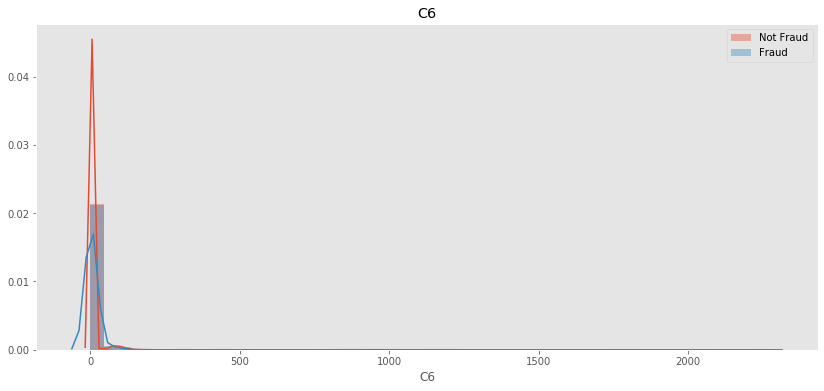

In [50]:
#Plot the five C column with lowest kurtosis
#Kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable

plot_dist(df, df_kurt.index.ravel()[:5])

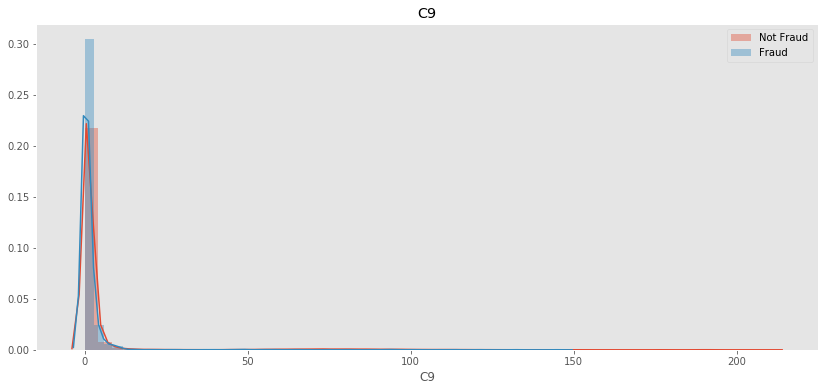

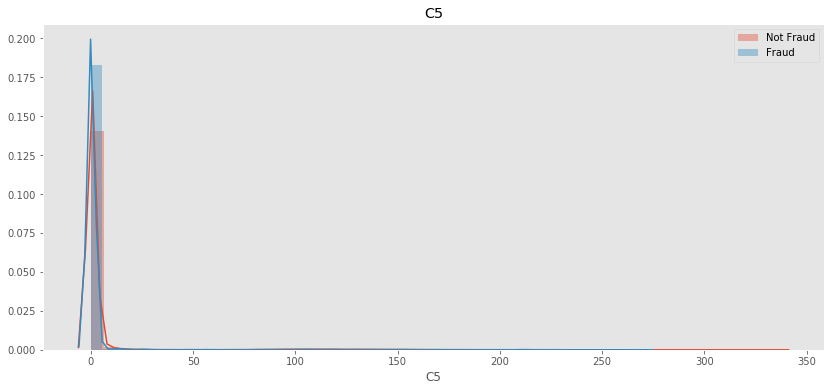

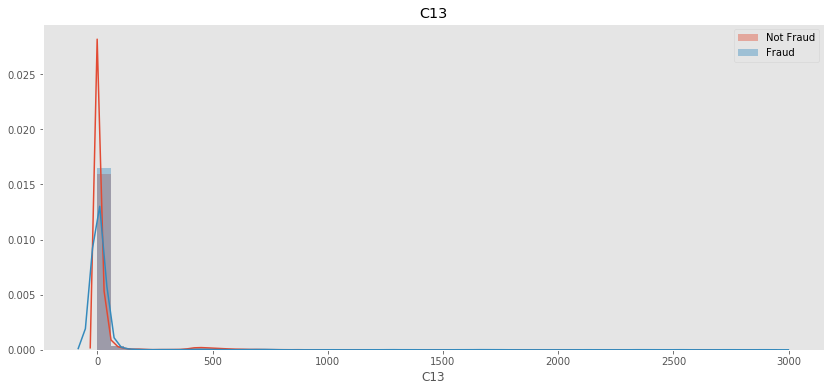

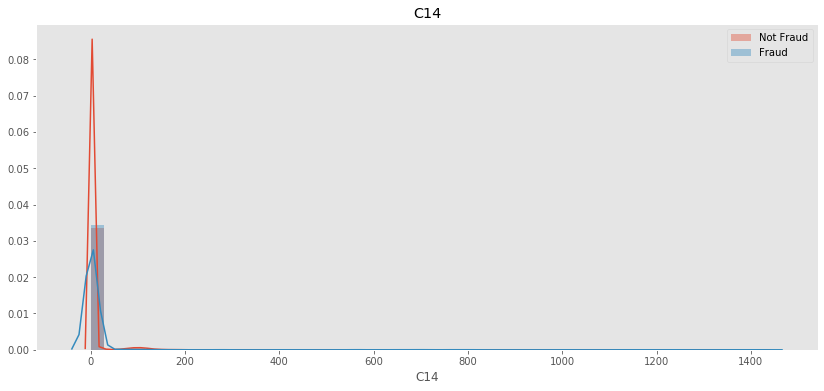

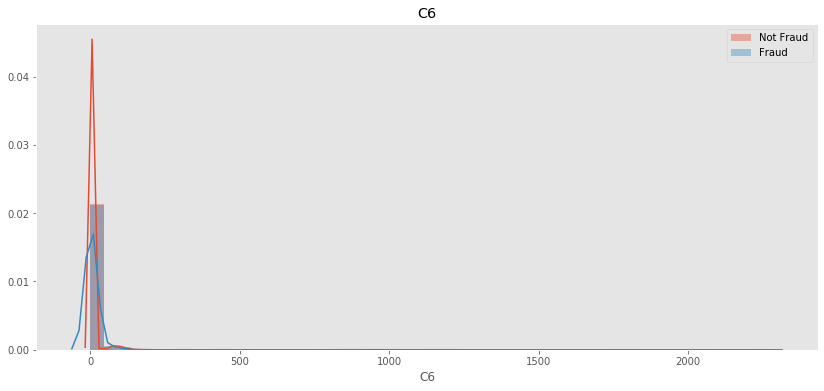

In [51]:
#Plot the five C column with lowest skewness
#Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. 
plot_dist(df, df_skew.index.ravel()[:5])

In [52]:
df.corr()

,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
isFraud,1.000000,0.018746,0.011231,0.033037,0.039917,-0.006775,0.032360,-0.031262,0.022840,0.032395,0.035177,-0.032537,0.031983,0.029781,0.035932,-0.007780,0.009833
TransactionDT,0.018746,1.000000,0.011199,-0.052838,-0.054896,-0.016873,-0.060046,0.028939,-0.051746,-0.057646,-0.060167,0.036877,-0.061526,-0.054518,-0.056823,-0.018794,-0.044238
TransactionAmt,0.011231,0.011199,1.000000,-0.019151,-0.019852,-0.006270,-0.012366,-0.029973,-0.018719,-0.017936,-0.016164,-0.028932,-0.017247,-0.018893,-0.018030,-0.039567,-0.023872
C1,0.033037,-0.052838,-0.019151,1.000000,0.995049,-0.003399,0.970514,0.158779,0.983906,0.937622,0.971163,0.168800,0.961736,0.996519,0.939404,0.789721,0.955094
C2,0.039917,-0.054896,-0.019852,0.995049,1.000000,-0.003241,0.975143,0.119713,0.977233,0.949404,0.978826,0.126501,0.973902,0.994290,0.950851,0.767588,0.940567
C3,-0.006775,-0.016873,-0.006270,-0.003399,-0.003241,1.000000,-0.001692,-0.007809,-0.004577,-0.001777,-0.001277,-0.009643,-0.001557,-0.003476,-0.001805,-0.007319,-0.004937
C4,0.032360,-0.060046,-0.012366,0.970514,0.975143,-0.001692,1.000000,-0.013280,0.964365,0.915721,0.968157,-0.016399,0.961309,0.976719,0.915261,0.669949,0.912749
C5,-0.031262,0.028939,-0.029973,0.158779,0.119713,-0.007809,-0.013280,1.000000,0.224252,-0.010622,-0.012144,0.923099,-0.012363,0.161662,-0.010592,0.696825,0.368133
C6,0.022840,-0.051746,-0.018719,0.983906,0.977233,-0.004577,0.964365,0.224252,1.000000,0.881364,0.932513,0.243059,0.925649,0.992064,0.880954,0.823933,0.984917
C7,0.032395,-0.057646,-0.017936,0.937622,0.949404,-0.001777,0.915721,-0.010622,0.881364,1.000000,0.986077,-0.013116,0.987908,0.930034,0.999512,0.660777,0.821281


In [171]:
df_scaled = df.drop(['isFraud','TransactionDT'],axis = 1,inplace=False)
df_scaled.head()

,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
17663,11.359375,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
380212,388.000000,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
130945,99.125000,1.0,5.0,0.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,3.0,3.0,2.0,1.0
97196,600.000000,1.0,3.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,3.0,1.0
497132,15.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0


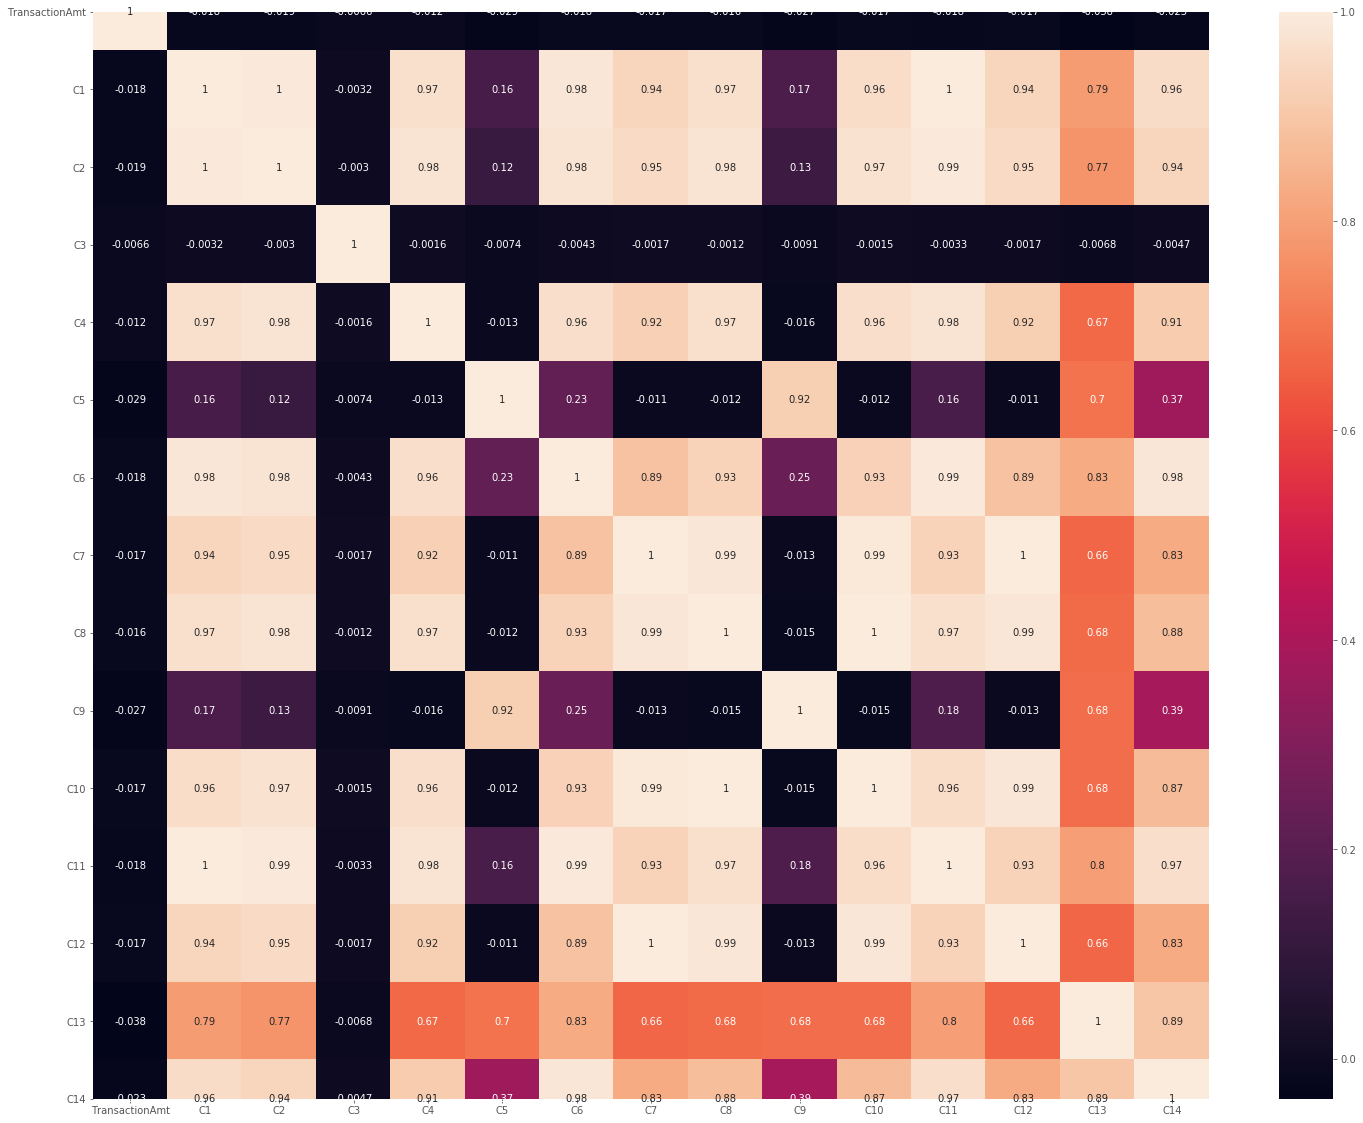

In [172]:
plt.figure(figsize=(25,20))
sns.heatmap(df_scaled.corr(),annot=True)
plt.show()

In [173]:
cordata=df_scaled[['C1','C2','C4','C6','C7', 'C8','C10','C11','C12','C14']]
cordata.head()

,C1,C2,C4,C6,C7,C8,C10,C11,C12,C14
17663,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
380212,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
130945,1.0,5.0,4.0,4.0,4.0,0.0,0.0,3.0,3.0,1.0
97196,1.0,3.0,3.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0
497132,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


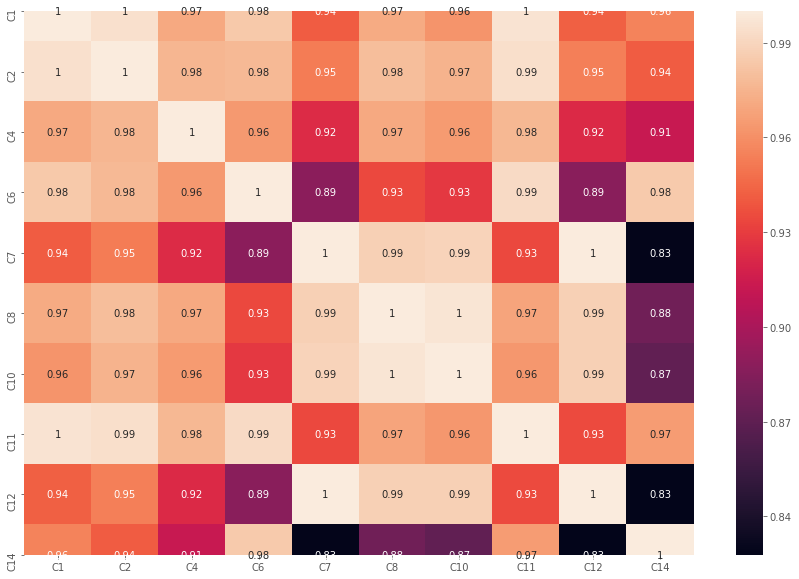

In [174]:
plt.figure(figsize=(15,10))
sns.heatmap(cordata.corr(),annot=True)
plt.show()

In [56]:
# Seperate total data into non-fraud and fraud cases
frauds = df[df['isFraud'] == 1]
non_frauds = df[df['isFraud'] == 0]

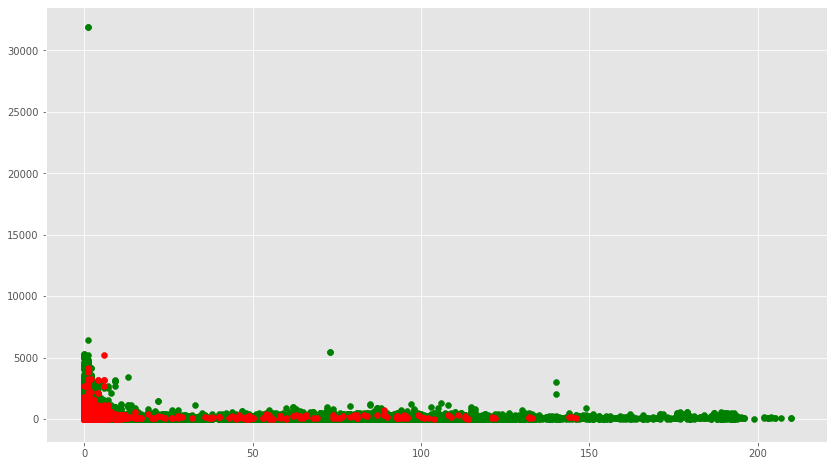

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(non_frauds['C9'],non_frauds['TransactionAmt'],c='g')
ax.scatter(frauds['C9'],frauds['TransactionAmt'],c='r')
plt.show()

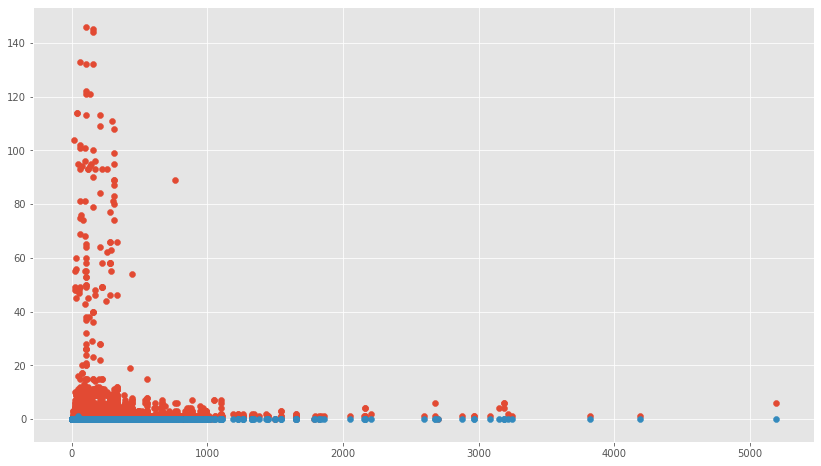

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C3'])
plt.show()

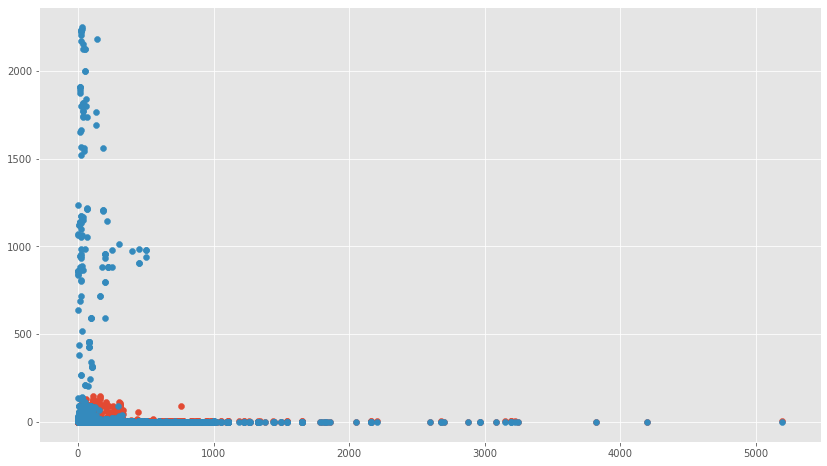

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C4'])
plt.show()

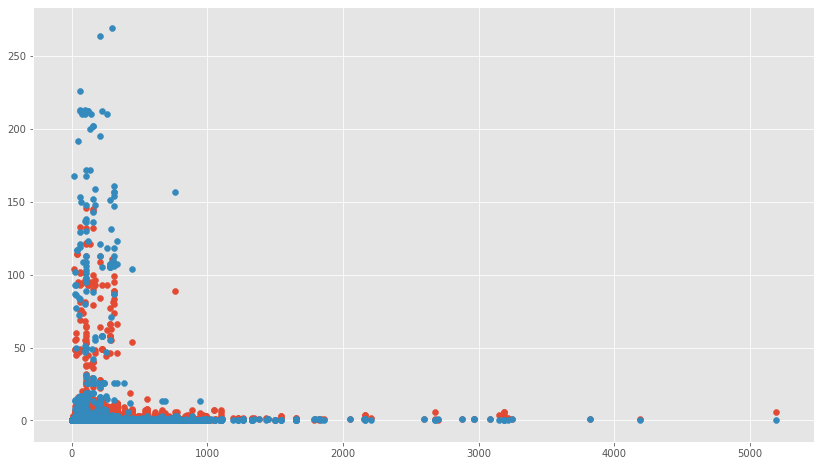

In [60]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C5'])
plt.show()

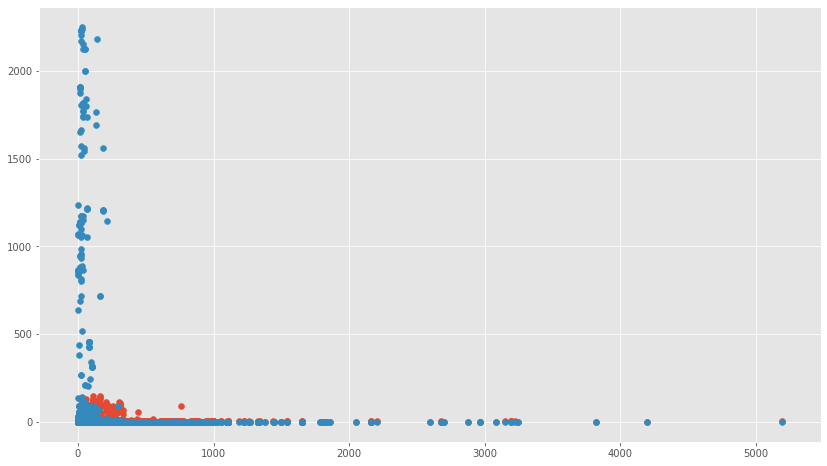

In [61]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C7'])
plt.show()

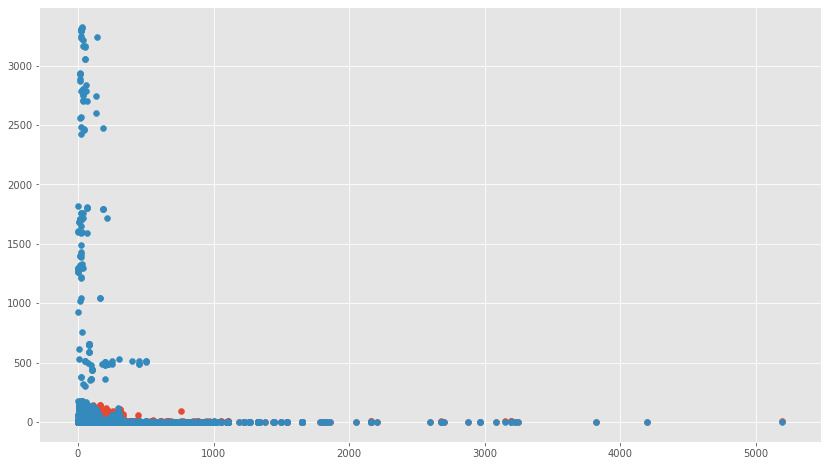

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C8'])
plt.show()

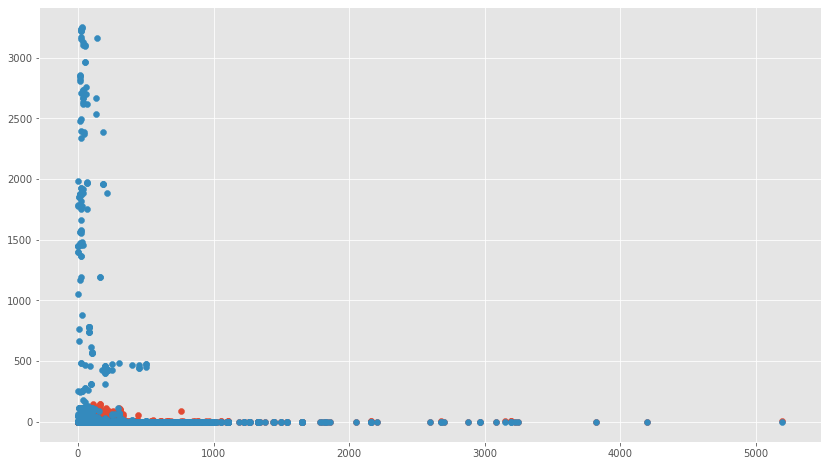

In [63]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C10'])
plt.show()

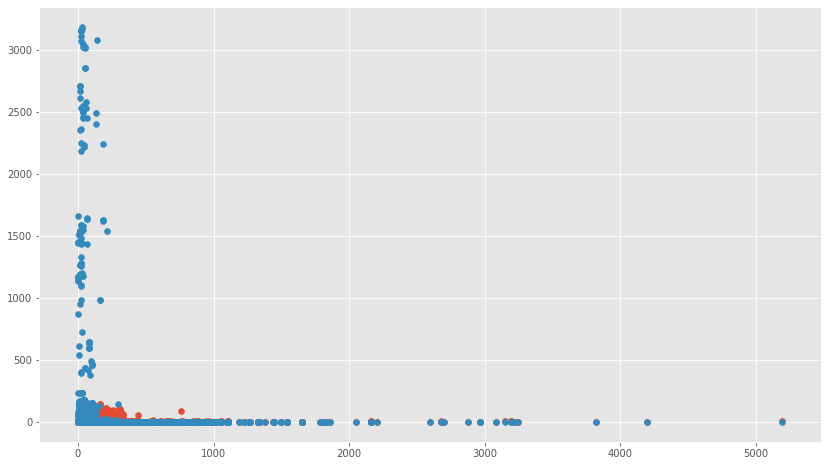

In [64]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C12'])
plt.show()

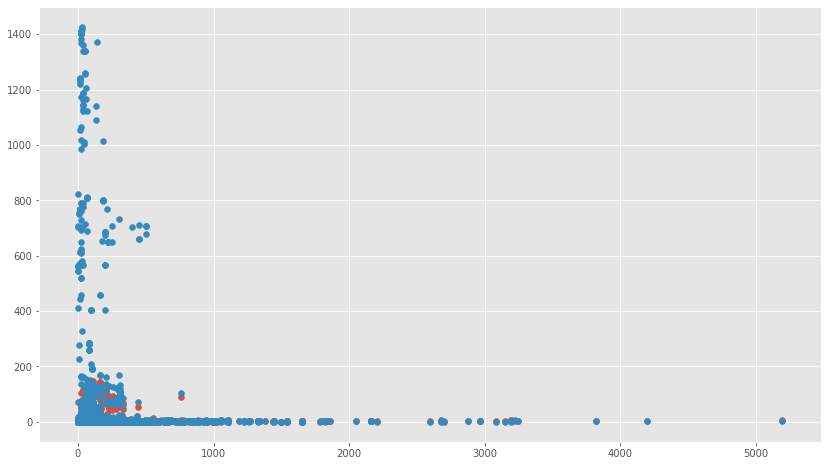

In [65]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(frauds['TransactionAmt'],frauds['C9'])
ax.scatter(frauds['TransactionAmt'],frauds['C14'])
plt.show()

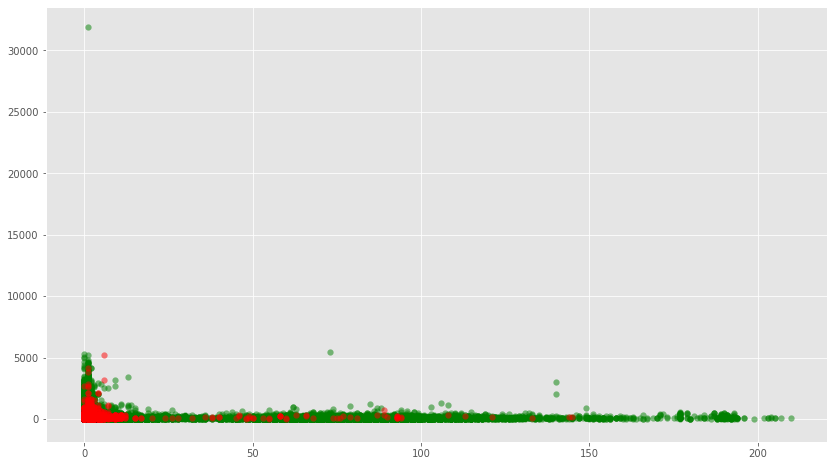

In [176]:
# Plot how fraud and non-fraud cases are scattered 
plt.scatter(df.loc[df['isFraud'] == 0]['C9'], df.loc[df['isFraud'] == 0]['TransactionAmt'],  label="isFraud #0", alpha=0.5, linewidth=0.15, c='g')
plt.scatter(df.loc[df['isFraud'] == 1]['C9'], df.loc[df['isFraud'] == 1]['TransactionAmt'], label="isFraud #1", alpha=0.5, linewidth=0.15,c='r')
plt.show()

### Transaction Amount Visualization

/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


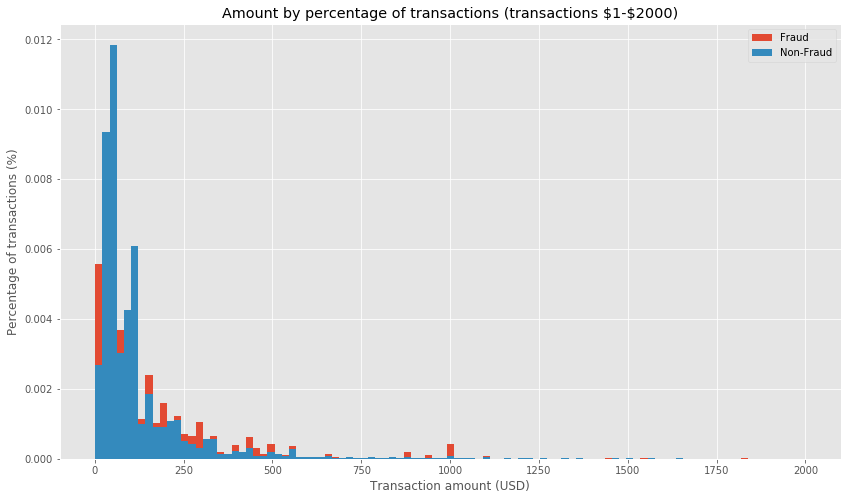

In [67]:
# Plot of high value transactions($1-$2000)
bins = np.linspace(1, 2000, 100)
plt.hist(frauds.TransactionAmt, bins, alpha=1, normed=True, label='Fraud')
plt.hist(non_frauds.TransactionAmt, bins, alpha=1, normed=True, label='Non-Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$1-$2000)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


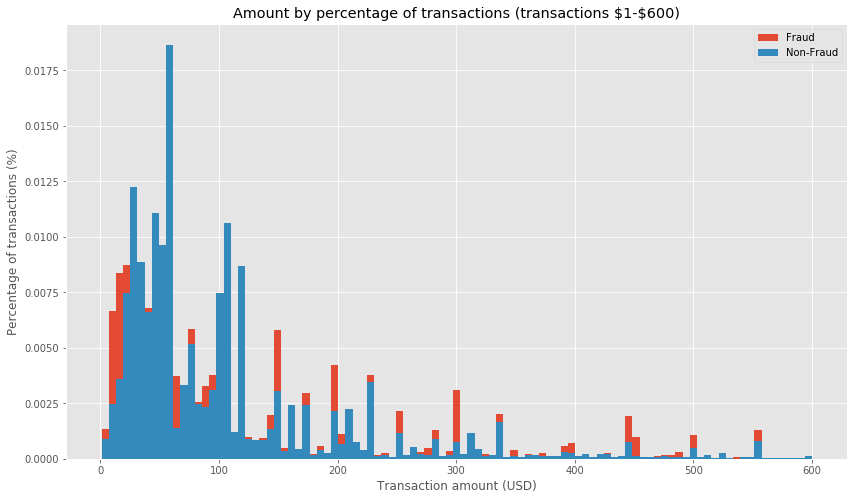

In [68]:
# Plot of high value transactions($1-$600)
bins = np.linspace(1, 600, 100)
plt.hist(frauds.TransactionAmt, bins, alpha=1, normed=True, label='Fraud')
plt.hist(non_frauds.TransactionAmt, bins, alpha=1, normed=True, label='Non-Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$1-$600)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


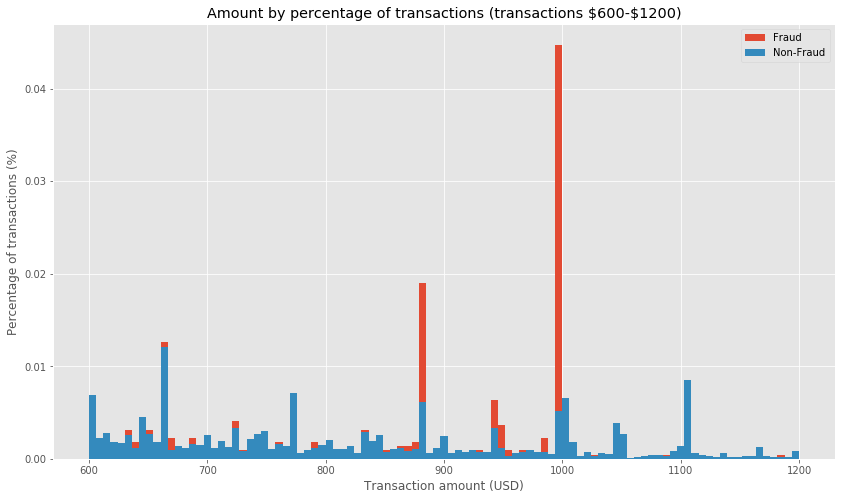

In [69]:
# Plot of high value transactions($600-$1200)
bins = np.linspace(600, 1200, 100)
plt.hist(frauds.TransactionAmt, bins, alpha=1, normed=True, label='Fraud')
plt.hist(non_frauds.TransactionAmt, bins, alpha=1, normed=True, label='Non-Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$600-$1200)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

In [70]:
df_scaled = df.drop(['isFraud','TransactionDT'],axis = 1,inplace=False)
df_scaled.head()

,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
219579,884.000000,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
470611,57.937500,49.0,60.0,0.0,0.0,33.0,35.0,0.0,0.0,34.0,0.0,36.0,0.0,255.0,40.0
101261,100.000000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
404121,3.927734,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
113257,50.000000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


Text(0.5, 1, 'Imbalanced Correlation Matrix \n')

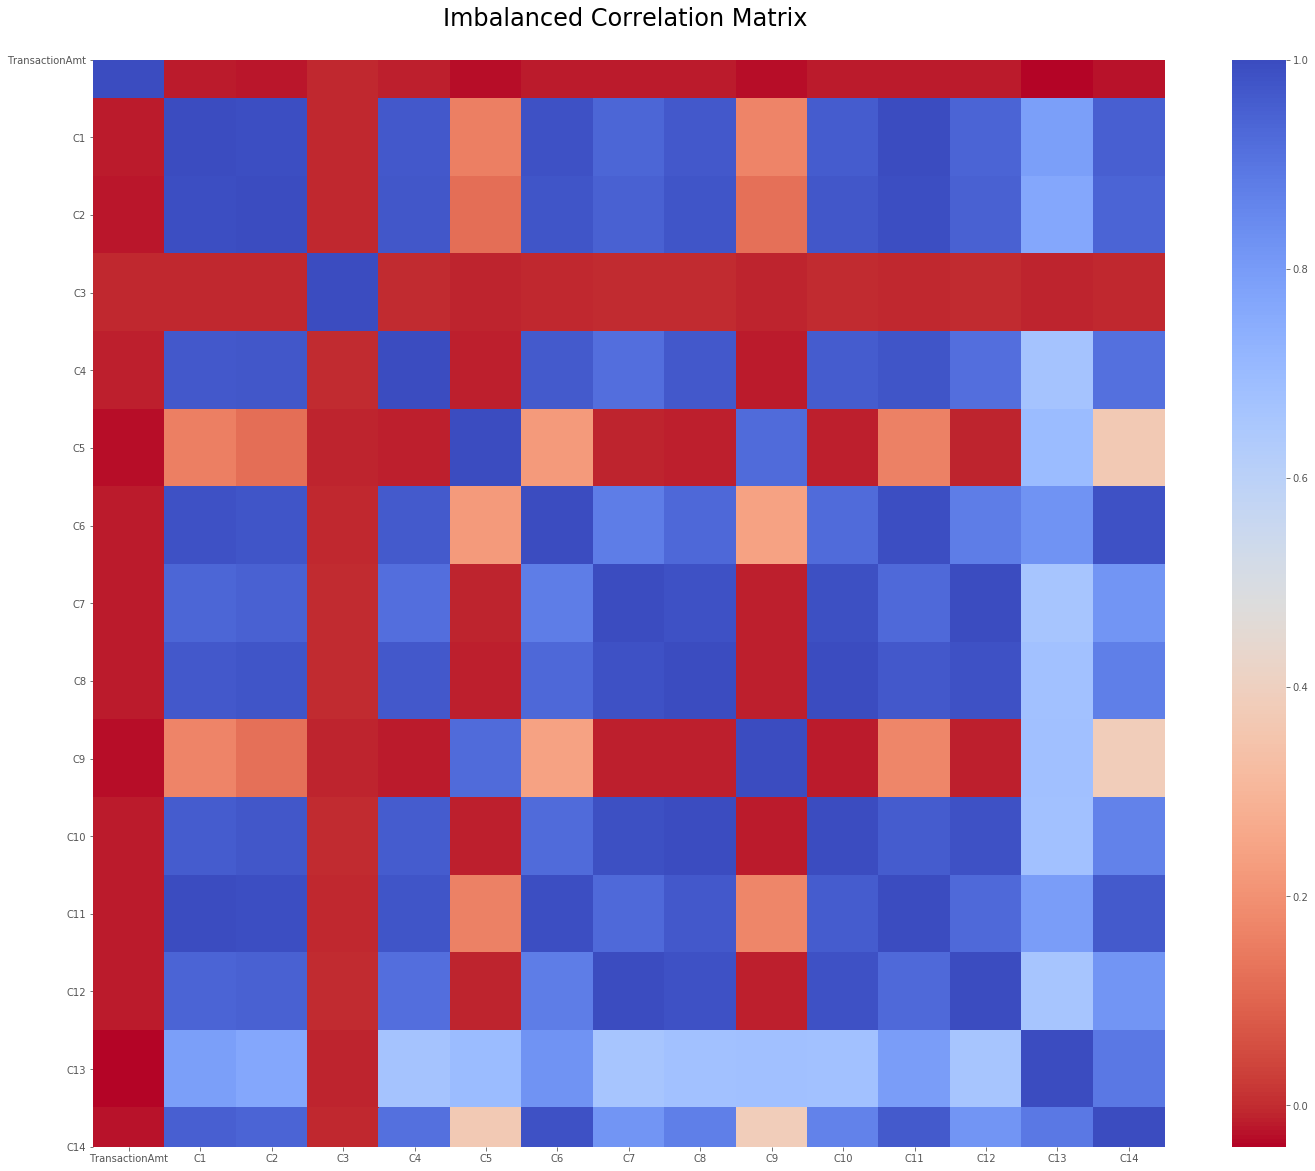

In [71]:
# Calculate pearson correlation coefficience
corr = df_scaled.corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
ax.set_title("Imbalanced Correlation Matrix \n", fontsize=24)

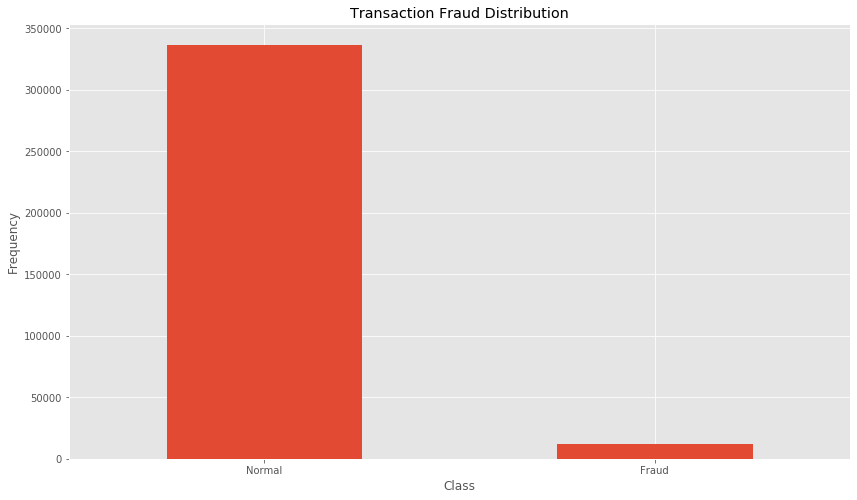

In [72]:
count_frauds = pd.value_counts(df['isFraud'], sort = True)
count_frauds.plot(kind = 'bar', rot=0)
plt.title("Transaction Fraud Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [73]:
outlier_fraction = len(frauds) / float(len(non_frauds))

print(outlier_fraction)

print('Fraud Cases: {}',format(len(frauds)))
print('Normal Cases: {}',format(len(non_frauds)))

0.03623296011404473
Fraud Cases: {} 12200
Normal Cases: {} 336710


In [74]:
#To see how different are the transaction amount of money used in Normal and Fraud 

In [75]:
frauds.TransactionAmt.describe()

count    12200.000000
mean       148.719317
std        230.468275
min          0.291992
25%         35.929688
50%         76.375000
75%        171.000000
max       5192.000000
Name: TransactionAmt, dtype: float64

In [76]:
non_frauds.TransactionAmt.describe()

count    336710.000000
mean        134.021068
std         240.732848
min           0.250977
25%          43.968750
50%          68.500000
75%         122.937500
max       31936.000000
Name: TransactionAmt, dtype: float64

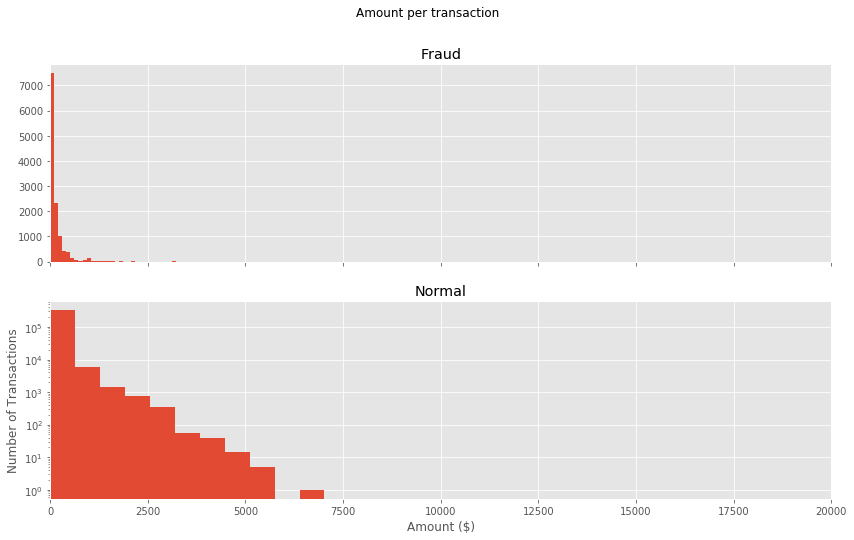

In [77]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction')
bins = 50
ax1.hist(frauds.TransactionAmt, bins = bins)
ax1.set_title('Fraud')
ax2.hist(non_frauds.TransactionAmt, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();